In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/football_commentary_balanced.csv")

In [3]:
label_counts = df['label'].value_counts()
print(label_counts)

label
PAST          50000
CURRENT       50000
IRRELEVANT    50000
Name: count, dtype: int64


In [4]:
# 🗂️ Load your balanced CSV
df = pd.read_csv("data/football_commentary_balanced.csv")

# 🔖 Encode class labels
label2id = {"CURRENT": 0, "PAST": 1, "IRRELEVANT": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["label"].map(label2id)

df.head()


,game,text,label
0,italy_serie-a/2015-2016/2015-09-20 - 13-30 Chi...,I said that the Argentine scored 22 goals in t...,1
1,spain_laliga/2019-2020/2019-12-14 - 18-00 Real...,eye to the lack,0
2,italy_serie-a/2016-2017/2016-12-01 - 18-00 Nap...,"Yes, she already loves to climb to the corner.",2
3,italy_serie-a/2015-2016/2015-08-29 - 21-45 AC ...,This too was born from a ball that seemed to b...,2
4,italy_serie-a/2016-2017/2016-09-21 - 21-45 Gen...,How he supports his former team.,2


In [5]:
import pandas as pd
from datasets import Dataset
from sklearn.metrics import classification_report
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

d:\VI\NLP\football-score-extension-float\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# Split into train/validation
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = dataset["train"]
val_ds = dataset["test"]


In [8]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
# 🔍 Ensure text column is all strings
train_ds = train_ds.filter(lambda x: isinstance(x["text"], str))
val_ds = val_ds.filter(lambda x: isinstance(x["text"], str))

Filter: 100%|██████████| 15000/15000 [00:00<00:00, 52478.92 examples/s]


In [10]:
def tokenize_fn(batch):
    texts = batch["text"] if isinstance(batch["text"], list) else [batch["text"]]
    return tokenizer(texts, truncation=True, padding=True)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

Map: 100%|██████████| 14998/14998 [00:02<00:00, 6956.97 examples/s]


In [11]:
# Remove only the present unused columns
train_ds = train_ds.remove_columns(["game", "text"])
val_ds = val_ds.remove_columns(["game", "text"])

# Set PyTorch format
train_ds.set_format("torch")
val_ds.set_format("torch")

In [12]:
# 🏗️ Load model
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# 🧪 Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ⚙️ TrainingArguments
args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

# 🏋️ Train
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


C:\Users\DELL\AppData\Local\Temp\ipykernel_14184\12926010.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
d:\VI\NLP\football-score-extension-float\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# 🧪 Final evaluation
predictions = trainer.predict(val_ds)
preds = predictions.predictions.argmax(-1)
print(classification_report(val_ds["label"], preds, target_names=label2id.keys()))
# Save the model
trainer.save_model("./football_score_model")

### Trial with Small ML

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class FootballTextClassifier:
    def __init__(self, model_type='logistic', vectorizer_type='tfidf'):
        """
        Football text classifier for PAST/CURRENT/IRRELEVANT classification
        
        Args:
            model_type: 'logistic', 'random_forest', 'naive_bayes', 'svm', 'gradient_boost'
            vectorizer_type: 'tfidf' or 'count'
        """
        self.model_type = model_type
        self.vectorizer_type = vectorizer_type
        self.pipeline = None
        self.label_encoder = LabelEncoder()
        self.classes_ = None
        
    def clean_text(self, text):
        """
        Comprehensive text cleaning for football commentary
        """
        if pd.isna(text):
            return ""
        
        text = str(text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # Convert to lowercase for consistency
        text = text.lower()
        
        # Remove special characters but keep important punctuation
        text = re.sub(r'[^\w\s\-\']', ' ', text)
        
        # Handle numbers and scores (keep them as they're important for football)
        # Don't remove numbers as "2-1", "22 goals" are important features
        
        # Remove extra spaces again
        text = ' '.join(text.split())
        
        return text.strip()
    
    def extract_temporal_features(self, text):
        """
        Extract temporal indicators from text
        """
        text_lower = text.lower()
        
        # Past indicators
        past_words = ['yesterday', 'last', 'ago', 'previous', 'former', 'past', 'scored', 'won', 'beat', 'defeated', 'finished']
        past_count = sum(1 for word in past_words if word in text_lower)
        
        # Current indicators  
        current_words = ['now', 'currently', 'today', 'this', 'ongoing', 'leading', 'playing', 'final score']
        current_count = sum(1 for word in current_words if word in text_lower)
        
        # Year patterns (tends to indicate past)
        year_pattern = len(re.findall(r'\b(19|20)\d{2}\b', text))
        
        return {
            'past_indicators': past_count,
            'current_indicators': current_count,
            'year_mentions': year_pattern,
            'text_length': len(text.split())
        }
    
    def create_vectorizer(self):
        """Create text vectorizer"""
        if self.vectorizer_type == 'tfidf':
            return TfidfVectorizer(
                max_features=8000,
                ngram_range=(1, 3),  # Unigrams, bigrams, and trigrams
                min_df=2,
                max_df=0.9,
                strip_accents='unicode',
                lowercase=True,
                stop_words='english',
                sublinear_tf=True,  # Apply sublinear scaling
                use_idf=True
            )
        else:
            return CountVectorizer(
                max_features=8000,
                ngram_range=(1, 3),
                min_df=2,
                max_df=0.9,
                strip_accents='unicode',
                lowercase=True,
                stop_words='english'
            )
    
    def create_model(self):
        """Create the ML model"""
        if self.model_type == 'logistic':
            return LogisticRegression(
                random_state=42,
                max_iter=2000,
                C=1.0,
                class_weight='balanced',
                solver='liblinear'
            )
        elif self.model_type == 'random_forest':
            return RandomForestClassifier(
                n_estimators=200,
                random_state=42,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                n_jobs=-1
            )
        elif self.model_type == 'naive_bayes':
            return MultinomialNB(alpha=0.1)
        elif self.model_type == 'svm':
            return SVC(
                kernel='rbf',
                random_state=42,
                class_weight='balanced',
                probability=True,
                C=1.0,
                gamma='scale'
            )
        elif self.model_type == 'gradient_boost':
            return GradientBoostingClassifier(
                n_estimators=100,
                random_state=42,
                max_depth=6,
                learning_rate=0.1
            )
        else:
            raise ValueError("Invalid model_type")
    
    def load_data(self, file_path):
        """
        Load and preprocess the dataset
        """
        print("Loading dataset...")
        
        # Try different separators and encodings
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except:
            try:
                df = pd.read_csv(file_path, encoding='latin-1')
            except:
                df = pd.read_csv(file_path, encoding='cp1252')
        
        print(f"Original dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Handle different possible column names
        text_col = None
        label_col = None
        
        for col in df.columns:
            if 'text' in col.lower():
                text_col = col
            elif 'label' in col.lower():
                label_col = col
        
        if text_col is None or label_col is None:
            print("Available columns:", df.columns.tolist())
            print("Please specify the correct column names")
            return
        
        # Extract text and labels
        self.texts = df[text_col].astype(str)
        self.labels = df[label_col].astype(str)
        
        # Remove rows with missing data
        valid_mask = (self.texts.str.strip() != '') & (self.labels.str.strip() != '')
        self.texts = self.texts[valid_mask]
        self.labels = self.labels[valid_mask]
        
        # Clean texts
        print("Cleaning texts...")
        self.texts = self.texts.apply(self.clean_text)
        
        # Remove empty texts after cleaning
        non_empty_mask = self.texts.str.strip() != ''
        self.texts = self.texts[non_empty_mask]
        self.labels = self.labels[non_empty_mask]
        
        # Encode labels
        self.numeric_labels = self.label_encoder.fit_transform(self.labels)
        self.classes_ = self.label_encoder.classes_
        
        print(f"Final dataset shape: {len(self.texts)} samples")
        print(f"Label distribution:")
        label_counts = Counter(self.labels)
        for label, count in label_counts.items():
            print(f"  {label}: {count} ({count/len(self.labels)*100:.1f}%)")
        
        # Show sample data
        print(f"\nSample texts:")
        for i in range(min(3, len(self.texts))):
            print(f"  Label: {self.labels.iloc[i]} | Text: {self.texts.iloc[i][:100]}...")
    
    def train(self, test_size=0.2, random_state=42):
        """
        Train the model
        """
        print(f"\nTraining {self.model_type} classifier with {self.vectorizer_type} vectorizer...")
        
        # Create pipeline
        vectorizer = self.create_vectorizer()
        model = self.create_model()
        
        self.pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.texts, self.numeric_labels,
            test_size=test_size,
            random_state=random_state,
            stratify=self.numeric_labels
        )
        
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        
        # Train
        self.pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred = self.pipeline.predict(X_test)
        
        # Store for later analysis
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = y_pred
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        
        print(f"\n=== RESULTS ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=self.classes_))
        
        return {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }
    
    def cross_validate(self, cv=5):
        """
        Perform cross-validation
        """
        print(f"Performing {cv}-fold cross-validation...")
        
        # Create pipeline if not exists
        if self.pipeline is None:
            vectorizer = self.create_vectorizer()
            model = self.create_model()
            self.pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', model)
            ])
        
        # Stratified K-Fold
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        # Cross-validate
        cv_scores = cross_val_score(
            self.pipeline, self.texts, self.numeric_labels,
            cv=skf, scoring='accuracy', n_jobs=-1
        )
        
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean accuracy: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")
        
        return cv_scores
    
    def predict(self, texts):
        """
        Predict labels for new texts
        """
        if isinstance(texts, str):
            texts = [texts]
        
        # Clean texts
        cleaned_texts = [self.clean_text(text) for text in texts]
        
        # Predict
        predictions = self.pipeline.predict(cleaned_texts)
        probabilities = self.pipeline.predict_proba(cleaned_texts)
        
        results = []
        for i, original_text in enumerate(texts):
            pred_label = self.label_encoder.inverse_transform([predictions[i]])[0]
            confidence = probabilities[i].max()
            
            prob_dict = {}
            for j, class_name in enumerate(self.classes_):
                prob_dict[class_name] = probabilities[i][j]
            
            results.append({
                'text': original_text,
                'cleaned_text': cleaned_texts[i],
                'prediction': pred_label,
                'confidence': confidence,
                'probabilities': prob_dict
            })
        
        return results
    
    def plot_confusion_matrix(self):
        """
        Plot confusion matrix
        """
        if not hasattr(self, 'y_test'):
            print("Model hasn't been trained yet!")
            return
        
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes_,
                   yticklabels=self.classes_)
        plt.title(f'Confusion Matrix - {self.model_type.upper()} + {self.vectorizer_type.upper()}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def analyze_errors(self, n_examples=5):
        """
        Analyze prediction errors
        """
        if not hasattr(self, 'y_test'):
            print("Model hasn't been trained yet!")
            return
        
        # Find misclassified examples
        errors = self.X_test[self.y_test != self.y_pred]
        true_labels = self.y_test[self.y_test != self.y_pred]
        pred_labels = self.y_pred[self.y_test != self.y_pred]
        
        print(f"Found {len(errors)} misclassified examples")
        print(f"\nShowing first {min(n_examples, len(errors))} errors:")
        
        for i in range(min(n_examples, len(errors))):
            true_label = self.label_encoder.inverse_transform([true_labels.iloc[i]])[0]
            pred_label = self.label_encoder.inverse_transform([pred_labels[i]])[0]
            
            print(f"\nError #{i+1}:")
            print(f"Text: {errors.iloc[i]}")
            print(f"True: {true_label} | Predicted: {pred_label}")
    
    def get_feature_importance(self, n_features=20):
        """
        Get most important features (for logistic regression)
        """
        if self.model_type != 'logistic':
            print("Feature importance only available for logistic regression")
            return
        
        if not hasattr(self, 'pipeline'):
            print("Model hasn't been trained yet!")
            return
        
        # Get feature names and coefficients
        vectorizer = self.pipeline.named_steps['vectorizer']
        classifier = self.pipeline.named_steps['classifier']
        
        feature_names = vectorizer.get_feature_names_out()
        
        print(f"Top {n_features} features per class:")
        
        for i, class_name in enumerate(self.classes_):
            coefficients = classifier.coef_[i]
            top_indices = np.argsort(np.abs(coefficients))[-n_features:]
            
            print(f"\n{class_name}:")
            for idx in reversed(top_indices):
                print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")

def compare_models(file_path, test_size=0.2):
    """
    Compare different models and vectorizers
    """
    models = ['logistic', 'random_forest', 'naive_bayes', 'svm']
    vectorizers = ['tfidf', 'count']
    
    results = []
    
    print("=" * 80)
    print("COMPARING DIFFERENT MODELS AND VECTORIZERS")
    print("=" * 80)
    
    for model_type in models:
        for vec_type in vectorizers:
            print(f"\n{'='*50}")
            print(f"Model: {model_type.upper()} | Vectorizer: {vec_type.upper()}")
            print('='*50)
            
            try:
                classifier = FootballTextClassifier(
                    model_type=model_type, 
                    vectorizer_type=vec_type
                )
                classifier.load_data(file_path)
                metrics = classifier.train(test_size=test_size)
                
                results.append({
                    'model': model_type,
                    'vectorizer': vec_type,
                    'accuracy': metrics['accuracy'],
                    'f1_macro': metrics['f1_macro'],
                    'f1_weighted': metrics['f1_weighted']
                })
                
            except Exception as e:
                print(f"Error with {model_type} + {vec_type}: {str(e)}")
                continue
    
    # Summary
    print(f"\n{'='*80}")
    print("FINAL COMPARISON")
    print('='*80)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('f1_macro', ascending=False)
    
    print(results_df.to_string(index=False, float_format='%.4f'))
    
    return results_df

def main():
    """
    Main function to run the classifier
    """
    # Replace with your dataset path
    FILE_PATH = 'data/football_commentary_balanced.csv'
    
    print("Football Text Classification Pipeline")
    print("=" * 50)
    
    # Option 1: Quick single model training
    print("Training single model...")
    classifier = FootballTextClassifier(model_type='logistic', vectorizer_type='tfidf')
    classifier.load_data(FILE_PATH)
    classifier.train()
    classifier.plot_confusion_matrix()
    
    # Test predictions
    test_texts = [
        "I said that the Argentine scored 22 goals in the past.",
        "Liverpool 2-1 Chelsea final score",
        "Manchester United beat Arsenal 3-0 yesterday",
        "The weather is nice today",
        "Messi is currently leading the scoring charts"
    ]
    
    print("\n" + "="*50)
    print("TEST PREDICTIONS")
    print("="*50)
    
    predictions = classifier.predict(test_texts)
    for pred in predictions:
        print(f"\nText: '{pred['text']}'")
        print(f"Prediction: {pred['prediction']} (confidence: {pred['confidence']:.3f})")
        print("Probabilities:", {k: f"{v:.3f}" for k, v in pred['probabilities'].items()})
    
    # Cross-validation
    print(f"\n{'='*50}")
    print("CROSS-VALIDATION")
    print('='*50)
    classifier.cross_validate()
    
    # Error analysis
    print(f"\n{'='*50}")
    print("ERROR ANALYSIS")
    print('='*50)
    classifier.analyze_errors()
    
    # Feature importance
    print(f"\n{'='*50}")
    print("FEATURE IMPORTANCE")
    print('='*50)
    classifier.get_feature_importance()
    
    # Option 2: Compare all models (uncomment to run)
    print(f"\n{'='*50}")
    print("COMPARING ALL MODELS")
    print('='*50)
    comparison_results = compare_models('data/football_commentary_balanced.csv')

if __name__ == "__main__":
    # Update this with your dataset path
    FILE_PATH = 'data/football_commentary_balanced.csv'  # CHANGE THIS TO YOUR FILE PATH
    
    # Simple usage
    classifier = FootballTextClassifier(model_type='logistic')
    classifier.load_data(FILE_PATH)
    classifier.train()
    
    # Test it
    results = classifier.predict([
        "The Argentine scored 22 goals in the past",
        "Current match is 2-1",
        "The weather is nice today"
    ])
    
    for r in results:
        print(f"'{r['text']}' -> {r['prediction']} ({r['confidence']:.3f})")

Loading dataset...
Original dataset shape: (150000, 3)
Columns: ['game', 'text', 'label']
Cleaning texts...
Final dataset shape: 149715 samples
Label distribution:
  PAST: 50000 (33.4%)
  CURRENT: 49715 (33.2%)
  IRRELEVANT: 50000 (33.4%)

Sample texts:
  Label: PAST | Text: i said that the argentine scored 22 goals in the past...
  Label: CURRENT | Text: eye to the lack...
  Label: IRRELEVANT | Text: yes she already loves to climb to the corner...

Training logistic classifier with tfidf vectorizer...
Training samples: 119772
Test samples: 29943

=== RESULTS ===
Accuracy: 0.9797
F1-Score (Macro): 0.9796
F1-Score (Weighted): 0.9797

Detailed Classification Report:
              precision    recall  f1-score   support

     CURRENT       0.96      0.98      0.97      9943
  IRRELEVANT       1.00      1.00      1.00     10000
        PAST       0.98      0.96      0.97     10000

    accuracy                           0.98     29943
   macro avg       0.98      0.98      0.98     29943
w

Loading dataset from: data/football_commentary_balanced.csv
Original dataset shape: (150000, 3)
Columns: ['game', 'text', 'label']
Using text column: 'text', label column: 'label'
Dataset size: 149981 samples
Label distribution: {'PAST': 50000, 'IRRELEVANT': 50000, 'CURRENT': 49981}
🚀 COMPREHENSIVE MODEL COMPARISON
Training samples: 119984, Test samples: 29997

📊 VECTORIZER: TF-IDF (1-2gram)
--------------------------------------------------
Logistic Regression  | Acc: 0.9773 | F1: 0.9773 | CV: 0.9757±0.001 | Time: 15.50s
Random Forest        | Acc: 0.9340 | F1: 0.9336 | CV: 0.9351±0.002 | Time: 22.90s
Naive Bayes          | Acc: 0.8577 | F1: 0.8520 | CV: 0.8530±0.002 | Time: 11.85s

📊 VECTORIZER: TF-IDF (1-3gram)
--------------------------------------------------
Logistic Regression  | Acc: 0.9789 | F1: 0.9789 | CV: 0.9774±0.001 | Time: 17.25s
Random Forest        | Acc: 0.9332 | F1: 0.9329 | CV: 0.9322±0.000 | Time: 25.37s
Naive Bayes          | Acc: 0.8689 | F1: 0.8646 | CV: 0.8640±

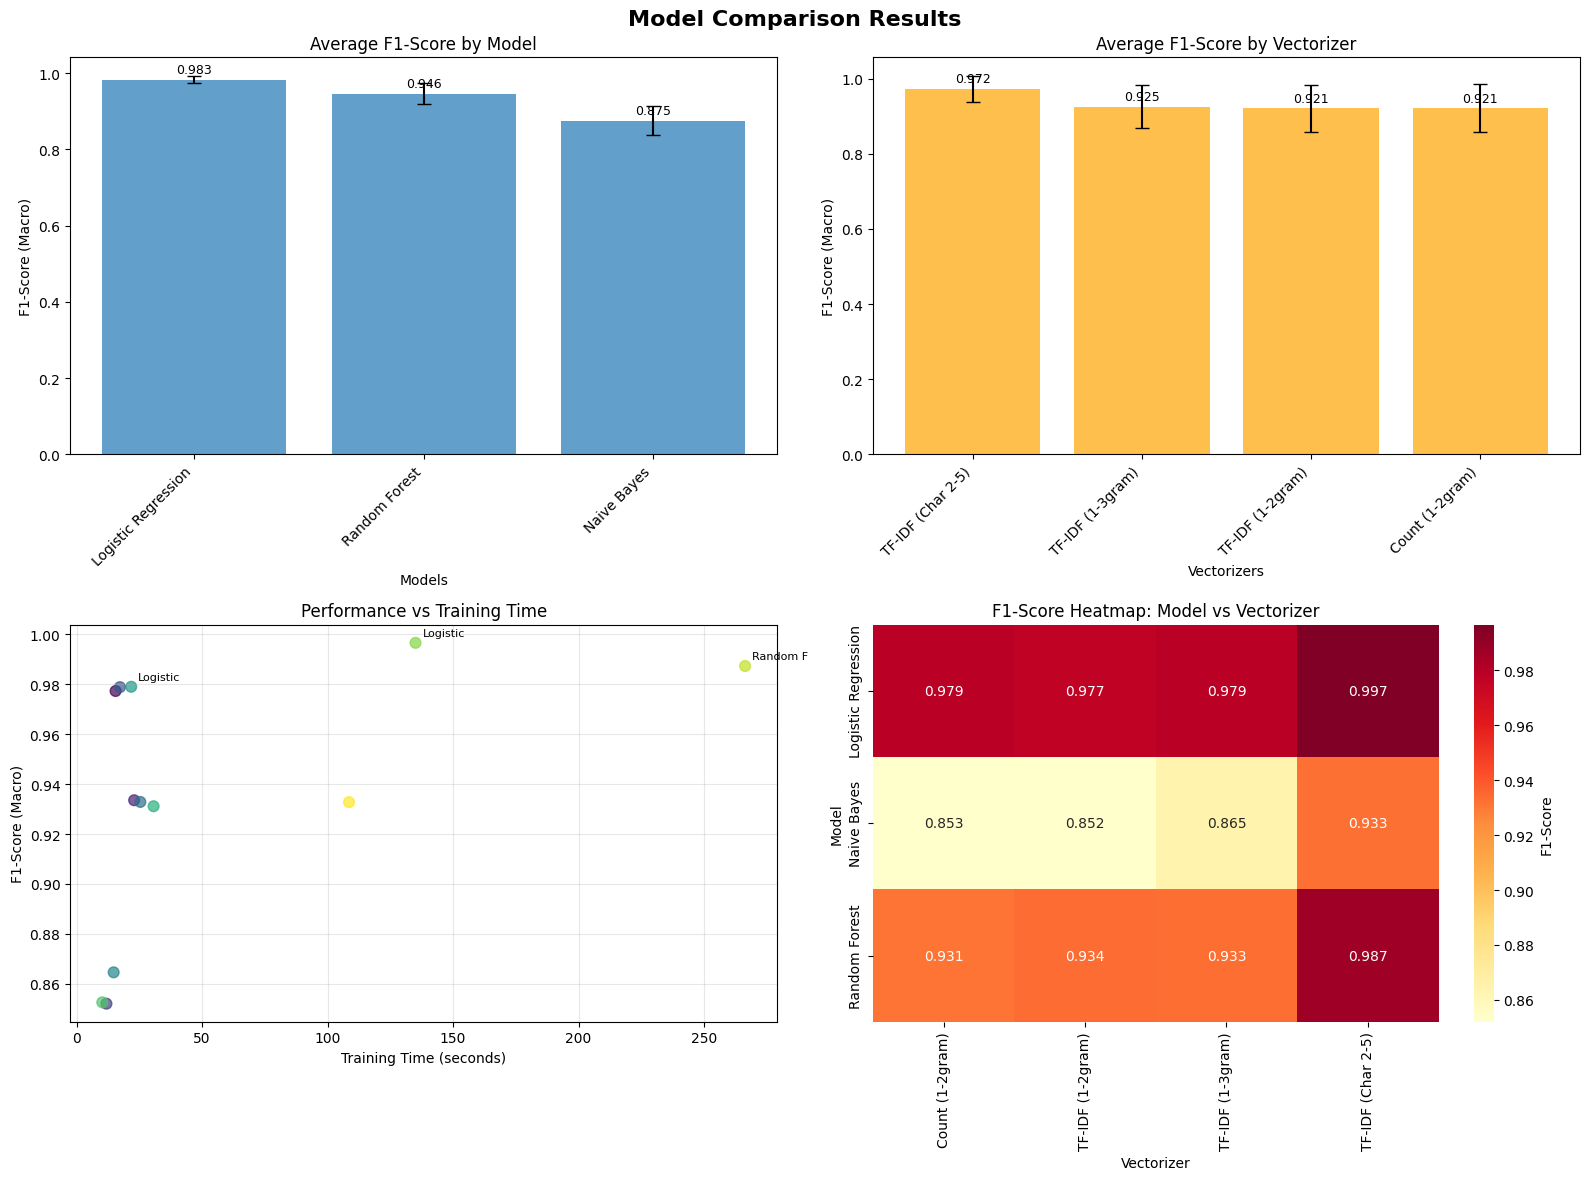


🧪 TESTING BEST MODEL: Logistic Regression + TF-IDF (Char 2-5)
------------------------------------------------------------

Text: 'The Argentine scored 22 goals in the past'
Prediction: PAST (confidence: 0.868)
Probabilities: CURRENT: 0.131 | IRRELEVANT: 0.001 | PAST: 0.868

Text: 'Current match is 2-1'
Prediction: CURRENT (confidence: 0.967)
Probabilities: CURRENT: 0.967 | IRRELEVANT: 0.000 | PAST: 0.032

Text: 'The weather is nice today'
Prediction: CURRENT (confidence: 0.994)
Probabilities: CURRENT: 0.994 | IRRELEVANT: 0.004 | PAST: 0.003

Text: 'Ronaldo finished as top scorer last season'
Prediction: PAST (confidence: 0.995)
Probabilities: CURRENT: 0.005 | IRRELEVANT: 0.000 | PAST: 0.995

Text: 'Barcelona is currently winning 3-0'
Prediction: CURRENT (confidence: 0.988)
Probabilities: CURRENT: 0.988 | IRRELEVANT: 0.009 | PAST: 0.003


In [1]:
# Enhanced Football Text Classification with Multiple Models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

class EnhancedFootballClassifier:
    def __init__(self):
        self.results = []
        self.best_model = None
        self.best_score = 0
        
    def create_models(self):
        """Create dictionary of all models to test"""
        return {
            'Logistic Regression': LogisticRegression(
                random_state=42, max_iter=2000, C=1.0, 
                class_weight='balanced', solver='liblinear'
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=100, random_state=42, max_depth=15,
                min_samples_split=5, class_weight='balanced', n_jobs=-1
            ),
            'Naive Bayes': MultinomialNB(alpha=0.1)
        }
    
    def create_vectorizers(self):
        """Create different vectorizer configurations"""
        return {
            'TF-IDF (1-2gram)': TfidfVectorizer(
                max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.9,
                stop_words='english', sublinear_tf=True
            ),
            'TF-IDF (1-3gram)': TfidfVectorizer(
                max_features=8000, ngram_range=(1, 3), min_df=2, max_df=0.9,
                stop_words='english', sublinear_tf=True
            ),
            'Count (1-2gram)': CountVectorizer(
                max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.9,
                stop_words='english'
            ),
            'TF-IDF (Char 2-5)': TfidfVectorizer(
                max_features=3000, analyzer='char', ngram_range=(2, 5),
                min_df=2, max_df=0.9
            )
        }
    
    def comprehensive_comparison(self, X, y, test_size=0.2):
        """Compare all model and vectorizer combinations"""
        models = self.create_models()
        vectorizers = self.create_vectorizers()
        
        # Split data once for fair comparison
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        print("🚀 COMPREHENSIVE MODEL COMPARISON")
        print("=" * 80)
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
        print("=" * 80)
        
        for vec_name, vectorizer in vectorizers.items():
            print(f"\n📊 VECTORIZER: {vec_name}")
            print("-" * 50)
            
            for model_name, model in models.items():
                start_time = time.time()
                
                try:
                    # Create pipeline
                    pipeline = Pipeline([
                        ('vectorizer', vectorizer),
                        ('classifier', model)
                    ])
                    
                    # Train
                    pipeline.fit(X_train, y_train)
                    
                    # Predict
                    y_pred = pipeline.predict(X_test)
                    y_pred_proba = None
                    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
                        y_pred_proba = pipeline.predict_proba(X_test)
                    
                    # Calculate metrics
                    accuracy = accuracy_score(y_test, y_pred)
                    f1_macro = f1_score(y_test, y_pred, average='macro')
                    f1_weighted = f1_score(y_test, y_pred, average='weighted')
                    
                    # Cross-validation for robustness
                    cv_scores = cross_val_score(
                        pipeline, X_train, y_train, cv=3, scoring='f1_macro'
                    )
                    
                    training_time = time.time() - start_time
                    
                    # Store results
                    result = {
                        'Vectorizer': vec_name,
                        'Model': model_name,
                        'Accuracy': accuracy,
                        'F1_Macro': f1_macro,
                        'F1_Weighted': f1_weighted,
                        'CV_Mean': cv_scores.mean(),
                        'CV_Std': cv_scores.std(),
                        'Training_Time': training_time,
                        'Pipeline': pipeline
                    }
                    
                    self.results.append(result)
                    
                    # Track best model
                    if f1_macro > self.best_score:
                        self.best_score = f1_macro
                        self.best_model = {
                            'pipeline': pipeline,
                            'name': f"{model_name} + {vec_name}",
                            'metrics': result
                        }
                    
                    # Print results
                    print(f"{model_name:20} | Acc: {accuracy:.4f} | "
                          f"F1: {f1_macro:.4f} | CV: {cv_scores.mean():.4f}±{cv_scores.std():.3f} | "
                          f"Time: {training_time:.2f}s")
                    
                except Exception as e:
                    print(f"{model_name:20} | ERROR: {str(e)[:50]}...")
                    continue
        
        return self.results
    
    def plot_comparison(self):
        """Create comprehensive comparison plots"""
        if not self.results:
            print("No results to plot!")
            return
        
        df = pd.DataFrame(self.results)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Model Comparison Results', fontsize=16, fontweight='bold')
        
        # 1. F1-Score by Model
        ax1 = axes[0, 0]
        model_f1 = df.groupby('Model')['F1_Macro'].agg(['mean', 'std']).reset_index()
        model_f1 = model_f1.sort_values('mean', ascending=False)
        
        bars1 = ax1.bar(range(len(model_f1)), model_f1['mean'], 
                       yerr=model_f1['std'], capsize=5, alpha=0.7)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('F1-Score (Macro)')
        ax1.set_title('Average F1-Score by Model')
        ax1.set_xticks(range(len(model_f1)))
        ax1.set_xticklabels(model_f1['Model'], rotation=45, ha='right')
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars1, model_f1['mean'])):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. F1-Score by Vectorizer
        ax2 = axes[0, 1]
        vec_f1 = df.groupby('Vectorizer')['F1_Macro'].agg(['mean', 'std']).reset_index()
        vec_f1 = vec_f1.sort_values('mean', ascending=False)
        
        bars2 = ax2.bar(range(len(vec_f1)), vec_f1['mean'], 
                       yerr=vec_f1['std'], capsize=5, alpha=0.7, color='orange')
        ax2.set_xlabel('Vectorizers')
        ax2.set_ylabel('F1-Score (Macro)')
        ax2.set_title('Average F1-Score by Vectorizer')
        ax2.set_xticks(range(len(vec_f1)))
        ax2.set_xticklabels(vec_f1['Vectorizer'], rotation=45, ha='right')
        
        for i, (bar, val) in enumerate(zip(bars2, vec_f1['mean'])):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Training Time vs Performance
        ax3 = axes[1, 0]
        scatter = ax3.scatter(df['Training_Time'], df['F1_Macro'], 
                             c=df.index, cmap='viridis', alpha=0.7, s=60)
        ax3.set_xlabel('Training Time (seconds)')
        ax3.set_ylabel('F1-Score (Macro)')
        ax3.set_title('Performance vs Training Time')
        ax3.grid(True, alpha=0.3)
        
        # Annotate best performing points
        top_3 = df.nlargest(3, 'F1_Macro')
        for _, row in top_3.iterrows():
            ax3.annotate(f"{row['Model'][:8]}", 
                        (row['Training_Time'], row['F1_Macro']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # 4. Detailed heatmap
        ax4 = axes[1, 1]
        pivot_table = df.pivot_table(
            values='F1_Macro', 
            index='Model', 
            columns='Vectorizer', 
            aggfunc='first'
        )
        
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd',
                   ax=ax4, cbar_kws={'label': 'F1-Score'})
        ax4.set_title('F1-Score Heatmap: Model vs Vectorizer')
        ax4.set_xlabel('Vectorizer')
        ax4.set_ylabel('Model')
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print detailed summary of results"""
        if not self.results:
            print("No results to summarize!")
            return
        
        df = pd.DataFrame(self.results)
        
        print("\n" + "="*80)
        print("🏆 FINAL RESULTS SUMMARY")
        print("="*80)
        
        # Top 10 combinations
        top_10 = df.nlargest(10, 'F1_Macro')[
            ['Model', 'Vectorizer', 'Accuracy', 'F1_Macro', 'F1_Weighted', 'CV_Mean', 'Training_Time']
        ]
        
        print("\n🥇 TOP 10 MODEL COMBINATIONS:")
        print("-" * 120)
        print(f"{'Rank':<4} {'Model':<20} {'Vectorizer':<18} {'Accuracy':<9} {'F1_Macro':<9} "
              f"{'F1_Wtd':<9} {'CV_Mean':<9} {'Time(s)':<8}")
        print("-" * 120)
        
        for i, (_, row) in enumerate(top_10.iterrows(), 1):
            print(f"{i:<4} {row['Model']:<20} {row['Vectorizer']:<18} "
                  f"{row['Accuracy']:<9.4f} {row['F1_Macro']:<9.4f} "
                  f"{row['F1_Weighted']:<9.4f} {row['CV_Mean']:<9.4f} {row['Training_Time']:<8.2f}")
        
        # Best model details
        if self.best_model:
            print(f"\n🎯 BEST OVERALL MODEL:")
            print(f"   {self.best_model['name']}")
            print(f"   F1-Score: {self.best_model['metrics']['F1_Macro']:.4f}")
            print(f"   Accuracy: {self.best_model['metrics']['Accuracy']:.4f}")
            print(f"   CV Score: {self.best_model['metrics']['CV_Mean']:.4f} ± {self.best_model['metrics']['CV_Std']:.3f}")
        
        # Model ranking
        print(f"\n📊 MODEL RANKINGS (by average F1-Score):")
        model_avg = df.groupby('Model')['F1_Macro'].mean().sort_values(ascending=False)
        for i, (model, score) in enumerate(model_avg.items(), 1):
            print(f"   {i}. {model:<20}: {score:.4f}")
        
        # Vectorizer ranking
        print(f"\n🔤 VECTORIZER RANKINGS (by average F1-Score):")
        vec_avg = df.groupby('Vectorizer')['F1_Macro'].mean().sort_values(ascending=False)
        for i, (vec, score) in enumerate(vec_avg.items(), 1):
            print(f"   {i}. {vec:<20}: {score:.4f}")
    
    def test_best_model(self, test_texts):
        """Test the best model on sample texts"""
        if not self.best_model:
            print("No best model found!")
            return
        
        print(f"\n🧪 TESTING BEST MODEL: {self.best_model['name']}")
        print("-" * 60)
        
        pipeline = self.best_model['pipeline']
        
        for text in test_texts:
            prediction = pipeline.predict([text])[0]
            probabilities = pipeline.predict_proba([text])[0]
            confidence = probabilities.max()
            
            print(f"\nText: '{text}'")
            print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
            
            # Show all probabilities
            classes = pipeline.classes_
            prob_str = " | ".join([f"{classes[i]}: {probabilities[i]:.3f}" 
                                  for i in range(len(classes))])
            print(f"Probabilities: {prob_str}")

def run_comprehensive_analysis(dataset_path=None):
    """
    Run the complete analysis pipeline
    """
    if dataset_path:
        # LOAD YOUR ACTUAL DATASET HERE
        print(f"Loading dataset from: {dataset_path}")
        
        # Try different encodings
        try:
            df = pd.read_csv(dataset_path, encoding='utf-8')
        except:
            try:
                df = pd.read_csv(dataset_path, encoding='latin-1')
            except:
                df = pd.read_csv(dataset_path, encoding='cp1252')
        
        print(f"Original dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Handle different possible column names - adjust these if needed
        text_col = None
        label_col = None
        
        # Look for text column
        for col in df.columns:
            if 'text' in col.lower() or 'comment' in col.lower() or 'message' in col.lower():
                text_col = col
                break
        
        # Look for label column  
        for col in df.columns:
            if 'label' in col.lower() or 'class' in col.lower() or 'category' in col.lower():
                label_col = col
                break
        
        if text_col is None or label_col is None:
            print("❌ Could not find text and label columns automatically!")
            print("Available columns:", df.columns.tolist())
            print("Please specify column names manually in the code")
            return None
        
        print(f"Using text column: '{text_col}', label column: '{label_col}'")
        
        # Extract and clean data
        X = df[text_col].astype(str).tolist()
        y = df[label_col].astype(str).tolist()
        
        # Remove empty or invalid entries
        valid_data = [(text, label) for text, label in zip(X, y) 
                     if text.strip() and label.strip() and text != 'nan']
        
        X = [item[0] for item in valid_data]
        y = [item[1] for item in valid_data]
        
    else:
        # Sample data for demonstration (fallback if no dataset provided)
        print("⚠️  No dataset path provided, using sample data for demonstration")
        sample_data = {
            'text': [
                # PAST examples
                "Argentina scored 22 goals in the past tournament",
                "Manchester United beat Chelsea 3-0 yesterday",
                "Messi won the Ballon d'Or last year",
                "Liverpool defeated Arsenal in the previous match",
                "The team finished second in 2019",
                # CURRENT examples  
                "Current match is 2-1 to Barcelona",
                "Liverpool is leading 1-0 right now",
                "The game is currently tied at 2-2",
                "Final score: Real Madrid 3-1 Bayern",
                "Manchester City is winning today",
                # IRRELEVANT examples
                "The weather is nice today",
                "I love pizza and ice cream", 
                "My car needs repair",
                "She is reading a book",
                "The movie was fantastic"
            ] * 100,  # Multiply to create more samples
            'label': (['PAST'] * 5 + ['CURRENT'] * 5 + ['IRRELEVANT'] * 5) * 100
        }
        
        X = sample_data['text']
        y = sample_data['label']
    
    print(f"Dataset size: {len(X)} samples")
    print(f"Label distribution: {pd.Series(y).value_counts().to_dict()}")
    
    # Run comprehensive comparison
    classifier = EnhancedFootballClassifier()
    results = classifier.comprehensive_comparison(X, y)
    
    # Print summary
    classifier.print_summary()
    
    # Plot results
    classifier.plot_comparison()
    
    # Test best model
    test_texts = [
        "The Argentine scored 22 goals in the past",
        "Current match is 2-1", 
        "The weather is nice today",
        "Ronaldo finished as top scorer last season",
        "Barcelona is currently winning 3-0"
    ]
    
    classifier.test_best_model(test_texts)
    
    return classifier

# Run the analysis
if __name__ == "__main__":
    # 🔥 PUT YOUR DATASET PATH HERE! 🔥
    DATASET_PATH = "data/football_commentary_balanced.csv"  # ← CHANGE THIS TO YOUR ACTUAL FILE PATH
    

    
    classifier = run_comprehensive_analysis(DATASET_PATH)
    
    # Alternative: If you want to specify column names manually
    # classifier = run_comprehensive_analysis_manual("your_dataset.csv", 
    #                                               text_col="text", 
    #                                               label_col="label")

### Saving the best model

In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

def train_and_save_model(dataset_path, model_save_path="football_classifier_model.pkl"):
    """
    Train Logistic Regression + TF-IDF (Char 2-5) model and save as pkl file
    """
    print("Loading dataset...")
    
    # Load dataset with different encoding attempts
    try:
        df = pd.read_csv(dataset_path, encoding='utf-8')
    except:
        try:
            df = pd.read_csv(dataset_path, encoding='latin-1')
        except:
            df = pd.read_csv(dataset_path, encoding='cp1252')
    
    print(f"Dataset loaded. Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Auto-detect text and label columns
    text_col = None
    label_col = None
    
    # Look for text column
    for col in df.columns:
        if 'text' in col.lower() or 'comment' in col.lower() or 'message' in col.lower():
            text_col = col
            break
    
    # Look for label column  
    for col in df.columns:
        if 'label' in col.lower() or 'class' in col.lower() or 'category' in col.lower():
            label_col = col
            break
    
    if text_col is None or label_col is None:
        print("❌ Could not find text and label columns automatically!")
        print("Available columns:", df.columns.tolist())
        return None
    
    print(f"Using text column: '{text_col}', label column: '{label_col}'")
    
    # Extract and clean data
    X = df[text_col].astype(str).tolist()
    y = df[label_col].astype(str).tolist()
    
    # Remove empty or invalid entries
    valid_data = [(text, label) for text, label in zip(X, y) 
                 if text.strip() and label.strip() and text != 'nan']
    
    X = [item[0] for item in valid_data]
    y = [item[1] for item in valid_data]
    
    print(f"Clean dataset size: {len(X)} samples")
    print(f"Label distribution: {pd.Series(y).value_counts().to_dict()}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Create the specific model pipeline: Logistic Regression + TF-IDF (Char 2-5)
    print("\nTraining Logistic Regression + TF-IDF (Char 2-5) model...")
    
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(
            max_features=3000, 
            analyzer='char', 
            ngram_range=(2, 5),
            min_df=2, 
            max_df=0.9
        )),
        ('classifier', LogisticRegression(
            random_state=42, 
            max_iter=2000, 
            C=1.0, 
            class_weight='balanced', 
            solver='liblinear'
        ))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Test the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save the model
    print(f"\nSaving model to: {model_save_path}")
    with open(model_save_path, 'wb') as f:
        pickle.dump(pipeline, f)
    
    print("✅ Model saved successfully!")
    
    # Test with sample texts
    test_texts = [
        "The Argentine scored 22 goals in the past",
        "Current match is 2-1", 
        "The weather is nice today",
        "Ronaldo finished as top scorer last season",
        "Barcelona is currently winning 3-0"
    ]
    
    print(f"\n🧪 Testing model on sample texts:")
    print("-" * 60)
    
    for text in test_texts:
        prediction = pipeline.predict([text])[0]
        probabilities = pipeline.predict_proba([text])[0]
        confidence = probabilities.max()
        
        print(f"\nText: '{text}'")
        print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
        
        # Show all class probabilities
        classes = pipeline.classes_
        prob_str = " | ".join([f"{classes[i]}: {probabilities[i]:.3f}" 
                              for i in range(len(classes))])
        print(f"Probabilities: {prob_str}")
    
    return pipeline

def load_and_test_model(model_path="football_classifier_model.pkl"):
    """
    Load the saved model and test it
    """
    print(f"Loading model from: {model_path}")
    
    with open(model_path, 'rb') as f:
        pipeline = pickle.load(f)
    
    print("✅ Model loaded successfully!")
    
    # Test the loaded model
    test_texts = [
        "Messi scored a hat-trick yesterday",
        "The match is currently 1-1",
        "I need to buy groceries today"
    ]
    
    print(f"\n🧪 Testing loaded model:")
    print("-" * 40)
    
    for text in test_texts:
        prediction = pipeline.predict([text])[0]
        probabilities = pipeline.predict_proba([text])[0]
        confidence = probabilities.max()
        
        print(f"\nText: '{text}'")
        print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
    
    return pipeline

if __name__ == "__main__":
    # 🔥 PUT YOUR DATASET PATH HERE! 🔥
    DATASET_PATH = "data/football_commentary_balanced.csv"  # ← CHANGE THIS TO YOUR ACTUAL FILE PATH
    MODEL_SAVE_PATH = "football_classifier_model.pkl"
    
    # Train and save the model
    trained_model = train_and_save_model(DATASET_PATH, MODEL_SAVE_PATH)
    
    if trained_model:
        print(f"\n{'='*60}")
        print("🎉 SUCCESS! Model has been trained and saved.")
        print(f"Model file: {MODEL_SAVE_PATH}")
        print("You can now use this .pkl file in other applications!")
        
        # Demonstrate loading the model
        print(f"\n{'='*60}")
        print("🔄 Demonstrating model loading...")
        loaded_model = load_and_test_model(MODEL_SAVE_PATH)

Loading dataset...
Dataset loaded. Shape: (150000, 3)
Columns: ['game', 'text', 'label']
Using text column: 'text', label column: 'label'
Clean dataset size: 149981 samples
Label distribution: {'PAST': 50000, 'IRRELEVANT': 50000, 'CURRENT': 49981}
Training samples: 119984, Test samples: 29997

Training Logistic Regression + TF-IDF (Char 2-5) model...

Model Performance:
Accuracy: 0.9966

Detailed Classification Report:
              precision    recall  f1-score   support

     CURRENT       1.00      0.99      1.00      9997
  IRRELEVANT       1.00      1.00      1.00     10000
        PAST       0.99      1.00      1.00     10000

    accuracy                           1.00     29997
   macro avg       1.00      1.00      1.00     29997
weighted avg       1.00      1.00      1.00     29997


Saving model to: football_classifier_model.pkl
✅ Model saved successfully!

🧪 Testing model on sample texts:
------------------------------------------------------------

Text: 'The Argentine sco